# Homework 5

In this homework, you'll review some linear algebra, and practice using `sklearn` and `scipy.optimize` to solve several variations of linear models.  You'll also use Pandas and Scikit learn for a simple machine learning task on a UCI data set.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la
import pandas as pd
import sklearn
import time
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from scipy.optimize import minimize

## Linear Models

A standard problem in statistics to solve the multivariate linear regression problem.
\begin{equation}
y = X * \beta + \epsilon
\end{equation}
The above notation is standard in statistics, but we'll use Householder notation by replacing $\beta$ with `b`
```
y = X * b + eps
```
`X` is known as the [design matrix](https://en.wikipedia.org/wiki/Design_matrix), and consists of `n` rows of observations, each of which has `p` features.  `y` is a vector of `n` responses.  `b` is an unknown vector of `p` coefficients which we would like to find.  `eps` (epsilon) is a vector of length `n` with random noise, typically i.i.d. normally distributed with variance `sig` (sigma).

In numpy notation, we could express this as
```python
y[i] = np.dot(X[i], b) + sig * np.random.randn()
```

We want to determine `b`, so that when me make a new observation `X[n]` we can predict the response `y[n]`.  Our goal is to minimize the mean square error

\begin{equation}
\mathop{\mathsf{minimize}}_b \mathbb{E}((X[n]*b - y[n])^2)
\end{equation}

The solution to this is the solution to the least squares problem
\begin{equation}
\mathop{\mathsf{minimize}}_b \frac{1}{n} \|X*b - y\|_2^2
\end{equation}

Where $n$ is the number of rows in $X$.  We'll let the solution to the problem be denoted $\hat{b}$, or `bhat`.

## Problem 0 - Linear Regression (30 points)

There are a variety of ways to solve the above problem.  We'll assume that $n > p$, meaning there are more observations than features.

### Generating Data

Write a function `gen_lstsq(n, p, sig=0.1)` which will generate a linear least squares problem (return `X`, `y`, and `b` as described above).  `b` is the "ground truth" coefficients that we are looking for.  You can generate the matrix `X` using `np.random.randn`, and generate `b` using `np.random.randn` as well.


In [2]:
## Your code here
def gen_lstsq(n, p, sig=0.1):
    """
    return X, y, b s.t.
    
    X@b = y
    """
    X = np.random.randn(n,p)
    b = np.random.randn(p)
    y = np.zeros(n)
    for i in range(n):
        y[i] = np.dot(X[i,:], b) + sig * np.random.randn()
    
    return X, y, b

### QR factorization

If we form a QR factorization $X = QR$, we can find $\hat{b} = R^{-1} Q^T y$.

Write a function `solve_lstsq_qr(X, y)` which estimates `b` using the QR factorization as above.

In [3]:
## Your code here
def solve_lstsq_qr(X, y):
    """
    solve least square problem
    
    using QR decomposition
    """
    p = X.shape[1]
    Q, R = la.qr(X)   
    # Assume X has full column rank, then Q[R 0]^T = X, where R \in R^{p*p} is a square matrix
    # Then Rb = Q1^ty, where Q1^ty is the first p entries of Q^ty.
    Rdense = R[:p,:]
    Qyd = ((Q.T).dot(y))[:p]
    bhat = la.solve_triangular(Rdense, Qyd, lower=False)
    
    return bhat

### Normal Equations

Often, this is the way statistics textbooks solve the problem: $\hat{b} = (X^T X)^{-1} X^T y$.  This is based on the normal equation $X^T X \hat{b} = X^T y$.

Write a function `solve_lstsq_normal(X, y)` which estimates `b` using the normal equations above.  You probably don't want to form the inverse - use an LU or Cholesky factorization instead.

In [4]:
## Your code here
def solve_lstsq_normal(X, y):
    """
    solve least square problem
    
    using normal equation
    """
    Xtemp = X.T@X
    P, L, U = la.lu(Xtemp)
    ytemp = (X.T).dot(y)
    
    bhat = la.solve_triangular(
            U,
            la.solve_triangular(
                L,
                P.T @ ytemp,
                lower=True
            ),
            lower=False
        )
    
    return bhat

### Check Your Work

Generate a few random problems to test that `solve_lstsq_qr` and `solve_lstsq_normal` give the same prediction $\hat{b}$ (measure $\|\hat{b}_{qr} - \hat{b}_{normal}\|_2$ and check it is smaller than `1e-4`).  Use $n > p$.  Check against `solve_lstsq` in numpy or scipy as well.

In [5]:
## Your code here
n = np.linspace(20, 200, 10)
p = np.linspace(10, 100, 10)

error = np.zeros(10)
error1 = np.zeros(10)
error2 = np.zeros(10)
for i in range(10):
    X, y, b = gen_lstsq((i+1)*20, (i+1)*10)
    bhN = solve_lstsq_normal(X, y)   # bhat for normal
    bhqr = solve_lstsq_qr(X, y)   # bhat for qr
    bla= la.lstsq(X, y)[0]   # bhat for LA.solve
    error[i] = la.norm(bhN-bhqr)
    error1[i] = la.norm(bla-bhqr)
    error2[i] = la.norm(bhN-bla)
print('the difference between bhat_qr and bhat_normal is smaller than 1e-4:', error<1e-4)
print('')
print('the difference between bhat_qr and bhat_lstsq is smaller than 1e-4:', error1<1e-4)
print('')
print('the difference between bhat_lstsq and bhat_normal is smaller than 1e-4:', error2<1e-4)


the difference between bhat_qr and bhat_normal is smaller than 1e-4: [ True  True  True  True  True  True  True  True  True  True]

the difference between bhat_qr and bhat_lstsq is smaller than 1e-4: [ True  True  True  True  True  True  True  True  True  True]

the difference between bhat_lstsq and bhat_normal is smaller than 1e-4: [ True  True  True  True  True  True  True  True  True  True]


### Estimate the Mean Squared Error

Write a function `mse` which estimates the mean squared error (MSE) $\mathbb{E}[\|X * \hat{b} - y\|_2^2]$.

The function should have the call signature `mse(b, bhat, N=100, sig=0.1)`  You can generate `X` to be `N x p` using `np.random.randn`, and set `y = X * b + sig * np.random.randn(p)` (use the same value of `sig` that you use when generating the data).  You can then estimate the MSE by computing $\frac{1}{N}\|X * \hat{b} - y\|_2^2$

Create a plot of the MSE vs the noise parameter `sig` (use the same value of `sig` when generating data and computing the MSE).  Put `sig` on a logartihmic axis ranging from `1e-4` to `10`.  Use `n=100`, `p=50` when generating data, and `N=100` when computing the MSE.  Put your plot on log-log axes.  Give it a title and axis labels.

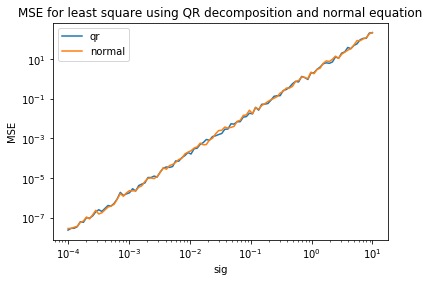

In [6]:
## Your code here
def mse(b, bhat, N=100, sig=0.1):
    """
    compute mse for least square
    """
    p = b.shape[0]
    X = np.random.randn(N,p)
    y = np.zeros(N)
    for i in range(N):
        y[i] = np.dot(X[i,:], b) + sig * np.random.randn()
    
    return (la.norm(X.dot(bhat)-y))**2/N


grid = np.logspace(np.log10(1e-4), 1, num=100, endpoint=True, base=10)
ng = grid.shape[0]
MSE1 = np.zeros(ng)
MSE2 = np.zeros(ng)

for i in range(ng):
    X, y, b = gen_lstsq(100, 50, sig=grid[i])  # generate X, y, b according to sig
    bhN = solve_lstsq_normal(X, y)
    bhqr = solve_lstsq_qr(X, y)
    MSE1[i] = mse(b, bhN, N=100, sig=grid[i])
    MSE2[i] = mse(b, bhqr, N=100, sig=grid[i])


plt.loglog(grid, MSE2, label='qr')   # loglog plot
plt.loglog(grid, MSE1, label='normal')
plt.title('MSE for least square using QR decomposition and normal equation')
plt.xlabel('sig')
plt.ylabel('MSE')
plt.legend()

### Discussion 1

Which of `solve_lstsq_qr` and `solve_lstsq_normal` is faster?  Give a justification for your answer (e.g. in terms of what you know about time to compute matrix multiplication and factorizations).

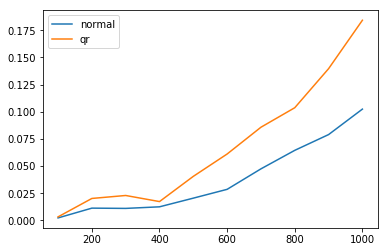

In [9]:
## Your code here
# The time complexity for QR decomposition should be around O(n^3) and LU decomposition should also be O(n^3)
# Both of them involving upper or lower triangular solving. Therefore, I believe that speed for both algorithm 
# should be quite approaching  when n is large. However, the LU decomposition will be faster in practically
# By my viewing from wiki. The time complexity for LU should be around 3/4*n^3 and 4/3*n^3 for QR. Therefore,
# for n being not too big, normal equation is faster.

# test for examples
size = np.linspace(100,1000,num=10)
t0 = np.zeros(10)
t1 = np.zeros(10)
for i in range(10):
    X, y, b = gen_lstsq(100*(i+1), 100*(i+1))  # generate X, y, b according to sig
    
    t00 = time.time()
    bhN = solve_lstsq_normal(X, y)
    t01 = time.time()
    t0[i] = t01-t00
    
    t10 = time.time()
    bhqr = solve_lstsq_qr(X, y)
    t11 = time.time()
    t1[i] = t11-t10 
plt.plot(size, t0, label='normal') 
plt.plot(size, t1, label='qr')
plt.legend()

---

_your discussion here_

### Optimization

Solve the minimization problem 
\begin{equation}
\mathop{\mathsf{minimize}}_b \frac{1}{n}\|X*b - y\|_2^2
\end{equation}

using `scipy.optimize.minimize`.  Wrap this in a function `solve_lstsq_opt(X, y)`.  Note that you can define the objective function inside `solve_lstsq_opt`

**Jacobian**: you should implement the Jacobian of the objective function to use in the optimization problem.  Here's a derivation:  We'd like to minimize the objective function
\begin{equation}
n f(b) = \|X*b - y\|_2^2 = (Xb - y)^T (Xb - y) = b^T X^T X b - 2 y^T X b + y^T y
\end{equation}

We might write the above expression as
\begin{equation}
n f(b) = \sum_{i,j} b_i (X^T X)_{i,j} b_j - 2\sum_{j,i} y_i X_{i,j} b_j + y^T y
\end{equation}

We can take a derivative with respect to $b_j$
\begin{equation}
n \frac{\partial f}{\partial b_j} = \sum_{i\ne j} b_i (X^T X)_{i,j} + \sum_{i\ne j} (X^T X)_{j,i} b_i + 2 (X^T X)_{j,j} b_j  - 2\sum_{i} y_i X_{i,j}
\end{equation}

Putting this in matrix form, we obtain
\begin{equation}
J_f(b) =  \frac{1}{n}\big( b^T (X^T X) + b^T (X^T X)^T - 2y^T X\big) = \frac{2}{n} b^T (X^T X) -\frac{2}{n}y^T X
\end{equation}

So we can write $J_f(b) = \frac{2}{n} b^T (X^T X) -\frac{2}{n} y^T X$

In [10]:
## Your code here
def solve_lstsq_opt(X, y):
    """
    solve least square problem
    
    using optimize.minimize
    """
    p = X.shape[1]
    n = X.shape[0]
    
    def leastsquare(b):
        """
        least square eqn to be minimize
        """
        return (((X.dot(b)).T).dot(X.dot(b))-2*(y.T).dot(X.dot(b))+(y.T).dot(y))/n
    
    def Jacobi(b):
        """
        derivative of the least square problem
        """
        return (2*(b.T).dot(X.T@X)-2*(y.T).dot(X))/n
    
    b0 = np.ones(p)
    res = minimize(leastsquare, b0, jac= Jacobi)
    return res.x

#### Check Your Work

Generate a few random problems to test that `solve_lstsq_opt` agrees with `solve_lstsq_qr` and `solve_lstsq_normal` in part A.  Use the same tolerance for checking.

In [11]:
## Your code here
n = np.linspace(20, 200, 10)
p = np.linspace(10, 100, 10)

error = np.zeros(10)
error1 = np.zeros(10)
for i in range(10):
    X, y, b = gen_lstsq((i+1)*20, (i+1)*10)
    bhN = solve_lstsq_normal(X, y)
    bhqr = solve_lstsq_qr(X, y)
    bhop = solve_lstsq_opt(X, y)
    error[i] = la.norm(bhN-bhop)
    error[i] = la.norm(bhqr-bhop)
print('error for solve_lstsq_opt agree with solve_lstsq_qr:', error1<1e-4)
print('')
print('error for solve_lstsq_opt agree with solve_lstsq_normal:', error<1e-4)

error for solve_lstsq_opt agree with solve_lstsq_qr: [ True  True  True  True  True  True  True  True  True  True]

error for solve_lstsq_opt agree with solve_lstsq_normal: [ True  True  True  True  True  True  True  True  True  True]


### Discussion 2

How fast is `solve_lstsq_opt` compared to the functions you wrote in part A?  Give some justification for what you see.

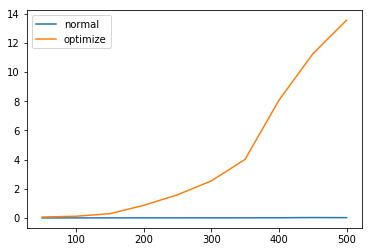

In [14]:
## Your code here
# For my code, the solve_lstsq_opt is much slower. Since we do a lot of matrix multiplication when constructing
# f(x) and Jf(x). Also, I am not very sure about the time complexity for optimizing.minimize for solving 
# the problem. But if it involves matrix multiplication (e.g. fixed point iteration), then I think it should
# be at least O(n^3) (or O(n^2.6)). Therefore, solve_lstsq_opt is the slowest.


size = np.linspace(50,500,num=10)
t0 = np.zeros(10)
t1 = np.zeros(10)
for i in range(10):
    X, y, b = gen_lstsq(50*(i+1), 50*(i+1))  # generate X, y, b according to sig
    
    t00 = time.time()
    bhN = solve_lstsq_normal(X, y)
    t01 = time.time()
    t0[i] = t01-t00
    
    t10 = time.time()
    bhqr = solve_lstsq_opt(X, y)
    t11 = time.time()
    t1[i] = t11-t10 
plt.plot(size, t0, label='normal') 
plt.plot(size, t1, label='optimize')
plt.legend()

---

_your discussion - you can add more code/markdown cells_

### Scikit Learn

Use [`sklearn.linear_model.LinearRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression) to solve the linear regression problem. You can get the vector `bhat` from `model.coef_`

Make a plot for the MSE like you did above using `LinearRegression` instead of a `solve_lstsq` function.  Set the keyword `fit_intercept=False`.

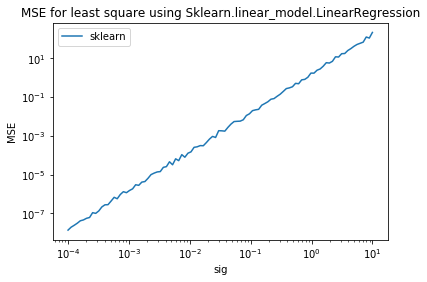

In [72]:
grid = np.logspace(np.log10(1e-4), 1, num=100, endpoint=True, base=10)
ng = grid.shape[0]
MSE3 = np.zeros(ng)


for i in range(ng):
    X, y, b = gen_lstsq(100, 50, sig=grid[i])
    reg = LinearRegression(fit_intercept=False).fit(X, y)   # use sklearn method
    bhs = reg.coef_   # get bhat
    MSE3[i] = mse(b, bhs, N=100, sig=grid[i])

plt.loglog(grid, MSE3, label='sklearn')   # the value of error is too small to be plotted in loglog
plt.title('MSE for least square using Sklearn.linear_model.LinearRegression')
plt.xlabel('sig')
plt.ylabel('MSE')
plt.legend()

## Problem 1 - Ridge Regression (15 points)

We'll now turn to the problem of what to do when `n < p` (there are fewer observations than features).  In this case we can solve $X * b = y$ exactly, but there are many possible values of $b$ which can satisfy the equation.

The normal equations are singular, and the $R$ term of the QR factorization is not invertible in this case.  We need to do something else.

Ridge regression seeks to solve the following optimization problem:

\begin{equation}
\mathop{\mathsf{minimize}}_b \frac{1}{n}\|X*b - y\|_2^2 + \lambda \|b\|_2^2
\end{equation}

$\lambda$ is a parameter you can choose to "regularize" the problem which you can choose.

### Optimization

Use `scipy.optimize.minimize` to minimize the above optimization problem.  Wrap this in a function `solve_ridge_opt(X, y, lam=0.1)` (`lam` should be provided as a keyword argument for the variable $\lambda$).

What is the Jacobian for the objective function for the minimization problem?  Incorporate this into your optimization problem.  Hint: differentiation is linear, so you just need to add a term to the Jacobian in Problem 0 based on the Jacobian of
\begin{equation}
\lambda \|b\|_2^2 = \lambda b^T b = \lambda \sum_i b_i^2
\end{equation}

---

_put the expression for the Jacobian here_

$J_f(b) = \frac{2}{n} b^T (X^T X) -\frac{2}{n} y^T X + 2 \lambda b^T$

In [76]:
## Your code here
def solve_ridge_opt(X, y, lam=0.1) :
    """
    solve ridge regression using
    
    optimize.minimize
    """
    n = X.shape[0]
    p = X.shape[1]
    
    def Ridge(b):
        """
        return the vectorized minimizing function
        
        in ridge regression
        """
        return (((X.dot(b)).T).dot(X.dot(b))-2*(y.T).dot(X.dot(b))+(y.T).dot(y))/n+lam*(b.T).dot(b)
    
    def Ridge_der(b):
        """
        return derivative of the ridge function
        """
        return (2*(b.T).dot(X.T@X)-2*(y.T).dot(X))/n+2*lam*b.T
    
    b0 = np.ones(p)
    res = minimize(Ridge, b0, jac= Ridge_der)
    return res.x

### Compute the MSE

Set `n = 50`, `p=100`, and `sig=0.1`.  Make a plot that displays the MSE of `bhat` computed using `solve_ridge_opt` as `lam` varies between `1e-4` and `1e2`.  Use a `semilogx` plot.

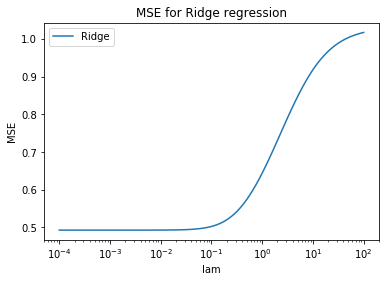

In [77]:
grid = np.logspace(np.log10(1e-4), 2, num=100, endpoint=True, base=10)
ng = grid.shape[0]
MSE = np.zeros(ng)
X, y, b = gen_lstsq(50, 100)

for i in range(ng):
    bhr = solve_ridge_opt(X, y, lam=grid[i])

    MSE[i] = mean_squared_error(b, bhr)   # use sklearn method to compute mse


plt.semilogx(grid, MSE, label='Ridge')
plt.title('MSE for Ridge regression')
plt.xlabel('lam')
plt.ylabel('MSE')
plt.legend()

### Scikit Learn

Use [`sklearn.linear_model.Ridge`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html) to solve the Ridge regression problem (note that this uses the keyword `alpha` where we have used `lam`). You can get the vector `bhat` from `model.coef_`

Make a plot for the MSE like you did above using `Ridge` instead of your `solve_ridge_opt` function.  In addition to the keyword `alpha`, set `fit_intercept=False`

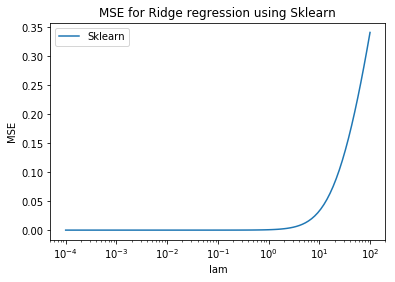

In [78]:
## Your code here
MSE1 = np.zeros(ng)
X, y, b = gen_lstsq(100, 50)

for i in range(ng):
    res = Ridge(alpha=grid[i], fit_intercept=False).fit(X, y)
    bhrs = res.coef_
    MSE1[i] = mean_squared_error(b, bhrs)

plt.semilogx(grid, MSE1, label='Sklearn')
plt.title('MSE for Ridge regression using Sklearn')
plt.xlabel('lam')
plt.ylabel('MSE')
plt.legend()

## Problem 2 - Lasso (15 points)

The Lasso is L1-regularized regression.  This is often used when `p > n`, and when the parameter vector `b` is assumed to be sparse, meaning that it has few non-zero entries.

The minimization problem is
\begin{equation}
\mathop{\mathsf{minimize}}_b \frac{1}{n} \|X * b - y\|_2^2 + \lambda \|b\|_1
\end{equation}

Where again, $\lambda$ can be chosen.

### Generate Data

We need to modify our generation of data to produce sparse `b`.  Write a function `gen_lstsq_sparse(n, p, sig=0.1, k=10)`, which generates `X` and `y` in the same way as `gen_lstsq`, but now `b` is generated to be a vector of length `p` with `k` random entries set to 1, and all other entries set to 0. Hint: look at `np.random.choice` for generating `k` random integers without replacement.

In [17]:
## Your code here
def gen_lstsq_sparse(n, p, sig=0.1, k=10):
    """
    return X, y, b, where
    
    b is sparse
    """
    X = np.random.randn(n,p)
    b = np.zeros(p)
    index = np.random.choice(np.arange(p), k)  # choose k indexes
    for i in range(k):
        b[index[i]] = 1
    y = np.zeros(n)
    for i in range(n):
        y[i] = np.dot(X[i,:], b) + sig * np.random.randn()
    
    return X, y, b

### Optimization

Recall we want to find `bhat` to solve
\begin{equation}
\mathop{\mathsf{minimize}}_b \frac{1}{n} \|X * b - y\|_2^2 + \lambda \|b\|_1
\end{equation}

Use `scipy.optimize.minimize` to minimize the above optimization problem.  Wrap this in a function `solve_lasso_opt(X, y, lam=0.1)` (`lam` should be provided as a keyword argument for the variable $\lambda$).

What is the Jacobian for the objective function for the minimization problem?  Incorporate this into your optimization problem.  Hint: differentiation is linear, so you just need to add a term to the Jacobian in Problem 0 based on the Jacobian of
\begin{equation}
\lambda \|b\|_1 = \lambda \sum_i |b_i|
\end{equation}

If $b_i$ is zero, then take $\partial_i |b_i| = 0$ (this is in the [subgradient](https://en.wikipedia.org/wiki/Subderivative)). Hint 2: look at `np.sign` for implementation

---

_put the expression for the Jacobian here_

If b_j = 0, then

\begin{equation}
\frac{\partial f}{\partial b_j} = \frac{2\sum_{i\ne j} b_i (X^T X)_{i,j} + 2 (X^T X)_{j,j} b_j  - 2\sum_{i} y_i X_{i,j}}{n}.
\end{equation}

In other situation, we have

\begin{equation}
\frac{\partial f}{\partial b_j} = \frac{2\sum_{i\ne j} b_i (X^T X)_{i,j} + 2 (X^T X)_{j,j} b_j  - 2\sum_{i} y_i X_{i,j}}{n} + \lambda \frac{b_j}{|b_j|}.
\end{equation}

In [18]:
## Your code here
def solve_lasso_opt(X, y, lam=0.1):
    """
    solve lasso regression
    
    return bhat
    """
    n = X.shape[0]
    p = X.shape[1]
    
    def Lasso(b):
        """
        return the minimizing function
        
        in lasso regression
        """
        return (((X.dot(b)).T).dot(X.dot(b))-2*(y.T).dot(X.dot(b))+(y.T).dot(y))/n+lam*la.norm(b, 1)
    
    def Lasso_der(b):
        """
        return derivatives of the function
        
        in lasso regression
        """
        return (2*(b.T).dot(X.T@X)-2*(y.T).dot(X))/n+lam*np.sign(b)
    
    b0 = np.ones(p)
    res = minimize(Lasso, b0, jac= Lasso_der)
    return res.x

### Compute the MSE

Set `n = 50`, `p=100`,`sig=0.1`, and `k=10` to generate a problem using `gen_lstsq_sparse`.  Make a plot that displays the MSE of `bhat` computed using `solve_lasso_opt` as `lam` varies between `1e-4` and `1e2`.  Use a `semilogx` plot.

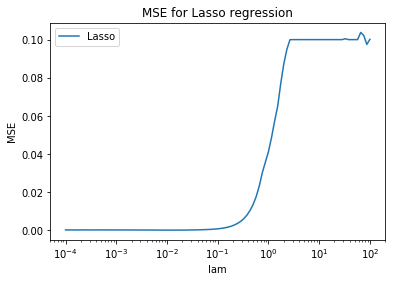

In [19]:
## Your code here
grid = np.logspace(np.log10(1e-4), 2, num=100, endpoint=True, base=10)
ng = grid.shape[0]
MSE = np.zeros(ng)
X, y, b = gen_lstsq_sparse(50, 100)

for i in range(ng):
    bhL = solve_lasso_opt(X, y, lam=grid[i])

    MSE[i] = mean_squared_error(b, bhL)


plt.semilogx(grid, MSE, label='Lasso')
plt.title('MSE for Lasso regression')
plt.xlabel('lam')
plt.ylabel('MSE')
plt.legend()

### Scikit Learn

Use [`sklearn.linear_model.Lasso`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html#sklearn.linear_model.Lasso) to solve the Lasso regression problem (note that this uses the keyword `alpha` where we have used `lam`). You can get the vector `bhat` from `model.coef_`

Make a plot for the MSE like you did above using `Lasso` instead of your `solve_lasso_opt` function.  In addition to the keyword `alpha`, set `fit_intercept=False`

/Users/lijinnan/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/lijinnan/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/lijinnan/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/lijinnan/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objectiv

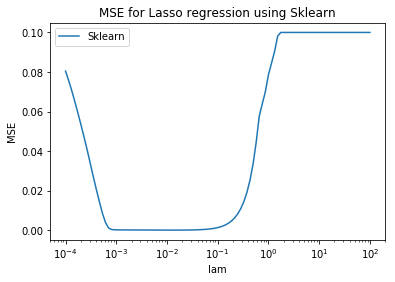

In [26]:
## Your code here
grid = np.logspace(np.log10(1e-4), 2, num=100, endpoint=True, base=10)  # guess we need to use large lam (e.g. from 1e-2 to 100)
MSE1 = np.zeros(ng)
X, y, b = gen_lstsq_sparse(50, 100)

for i in range(ng):
    res = Lasso(alpha=grid[i], fit_intercept=False).fit(X, y)
    bhLs = res.coef_
    MSE1[i] = mean_squared_error(b, bhLs)

plt.semilogx(grid, MSE1, label='Sklearn')
plt.title('MSE for Lasso regression using Sklearn')
plt.xlabel('lam')
plt.ylabel('MSE')
plt.legend()

## Problem 3 - Elastic Net (20 points)

Another option when `p > n` is the [Elastic Net]() which combines L1 and L2 regularization.

\begin{equation}
\mathop{\mathsf{minimize}}_b \frac{1}{n} \|X * b - y\|_2^2 + \lambda_1 \|b\|_1 + \lambda_2 \|b\|_2^2
\end{equation}
Where we get to choose $\lambda_1$ and $\lambda_2$.

You can find a function that does this in [`sklearn.linear_model.ElasticNet`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html#sklearn.linear_model.ElasticNet).

In this problem, you'll write a class that emulates the behavior of a Scikit learn class. Use `scipy.optimize.minimize` to solve the optimization problem.


### Jacobian

Give an expression for the Jacobian for the optimization objective function.  You've already done all the hard work for this in problems 1 and 2

---

_put the Jacobian expression here_

If b_j = 0, then

\begin{equation}
\frac{\partial f}{\partial b_j} = \frac{2\sum_{i\ne j} b_i (X^T X)_{i,j} + 2 (X^T X)_{j,j} b_j  - 2\sum_{i} y_i X_{i,j}}{n} + 2 \lambda b_j.
\end{equation}

In other situation, we have

\begin{equation}
\frac{\partial f}{\partial b_j} = \frac{2\sum_{i\ne j} b_i (X^T X)_{i,j} + 2 (X^T X)_{j,j} b_j  - 2\sum_{i} y_i X_{i,j}}{n} + \lambda \frac{b_j}{|b_j|} + 2 \lambda b_j.
\end{equation}

### Write the Class

Define a Python Class `ElasticNet`.  When you initialize the class you should be able to provide keyword arguments `lam1` for $\lambda_1$ and `lam2` for $\lambda_2$.  Give each these keyword arguments a default value of `0.5`.

In addition to `__init__`, your class should provide two methods:
1. `fit(X, y)` - sets an attribute `bhat` which solves the optimization problem (use the parameters `lam1` and `lam2` provided in initialization).  Use `scipy.optimize.minimize`
2. `predict(X)` - predict values of `y` as `X @ bhat`

In [29]:
## Your code here

class ElasticNet(object):
    
    def __init__(self, lam1=0.5, lam2=0.5):
        self.lam1 = lam1
        self.lam2 = lam2
        self.bhat = np.array([])
        
    def fit(self, X, y):
        """
        solve the elastic net problem
        
        and assign attribute bhat
        """
        n = X.shape[0]
        p = X.shape[1]
        def Elastic(b):
            """
            return the minimizing objective function
            
            in elastic net regression
            """
            return (((X.dot(b)).T).dot(X.dot(b))-2*(y.T).dot(X.dot(b))+(y.T).dot(y))/n+self.lam1*la.norm(b, 1)+self.lam2*(b.T).dot(b)
    
        def Elastic_der(b):
            """
            derivative of the function
            
            in elastic net regression
            """
            return (2*(b.T).dot(X.T@X)-2*(y.T).dot(X))/n+self.lam1*np.sign(b)+2*self.lam2*b.T
        
        b0 = np.ones(p)
        res = minimize(Elastic, b0, jac= Elastic_der)
        self.bhat = res.x
        return self
    
    def predict(self, X):
        """
        predict y by y = X@bhat
        """
        return X.dot(self.bhat)

### Compute the MSE

Set `n=50`, `p=100`,`sig=0.1`, and `k=10` to generate a problem using `gen_lstsq_sparse`.  

Set `n=50`, `p=100`, and `sig=0.1` to generate a problem using `gen_lstsq`.

Make a plot that displays the MSE of the model computed using your `ElasticNet` class using `lam1=lam2` varying between `1e-4` and `1e2` for each of the generated problems (your plot should have 2 lines).  Give your plot a title, axis labels, and a legend.

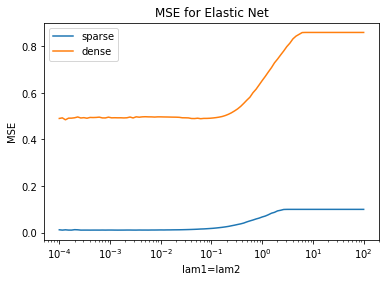

In [31]:
grid = np.logspace(np.log10(1e-4), 2, num=100, endpoint=True, base=10)
ng = grid.shape[0]
MSE1 = np.zeros(ng)
MSE2 = np.zeros(ng)

X1, y1, b1 = gen_lstsq_sparse(50, 100)
X2, y2, b2 = gen_lstsq(50, 100)

for i in range(ng):
    Elastic1 = ElasticNet(grid[i], grid[i])
    Elastic2 = ElasticNet(grid[i], grid[i])
    Elastic1.fit(X1, y1)
    Elastic2.fit(X2, y2)
    
    MSE1[i] = mean_squared_error(b1, Elastic1.bhat)
    MSE2[i] = mean_squared_error(b2, Elastic2.bhat)


plt.semilogx(grid, MSE1, label='sparse')
plt.semilogx(grid, MSE2, label='dense')
plt.title('MSE for Elastic Net')
plt.xlabel('lam1=lam2')
plt.ylabel('MSE')
plt.legend()

## Problem 4 - Real Data (20 points)

In this problem you'll use the [Wine Quality Data Set](https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/).  We'll focus on the red wines found in [`winequality-red.csv`](https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv).  The goal is to train a machine learning model that will predict the wine quality from a variety of other features.

### Load the data set

Load the wines in `windquality-red.csv` into a Pandas data frame. Note that this file has column labels, which are interpreted in the data set documentation:

Input variables (based on physicochemical tests):
1. fixed acidity
2. volatile acidity
3. citric acid
4. residual sugar
5. chlorides
6. free sulfur dioxide
7. total sulfur dioxide
8. density
9. pH
10. sulphates
11. alcohol

Output variable (based on sensory data):

12. quality (score between 0 and 10)

Note that this file uses semi-colons `;` to delimit values.  You can use `delimiter=';'` as a keyword argument.

In [106]:
## Your code here
red = pd.read_csv('winequality-red.csv', delimiter=';')
y = red['quality']
X = red.iloc[:, :11]

The first 11 columns will be features for the model (used in the design matrix `X`), and the last column (quality) is the quantity we're tyring to predict (the response `y`).

### Split the Data in to Training and Testing Sets

Split the data `X, y` into `X_train, y_train, X_test, y_test` using `sklearn`.  Use 70% of the data for training, and 30% of the data for testing.


In [114]:
## Your code here
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

7

### Train a Model and Measure Error

Use [`sklearn.linear_model.LinearRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression) to fit a linear regression model to your training data.

Use [`sklearn.metrics.mean_squared_error`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html#sklearn.metrics.mean_squared_error) to compute the MSE on your test set.

In [116]:
## Your code here
reg = LinearRegression(fit_intercept=False).fit(X_train, y_train)
yhat = reg.predict(X_test)
MSE = mean_squared_error(y_test, yhat)
print(MSE)

0.43524249329098386
